# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
import pandas as pd

#Added libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import numpy as np





In [ ]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

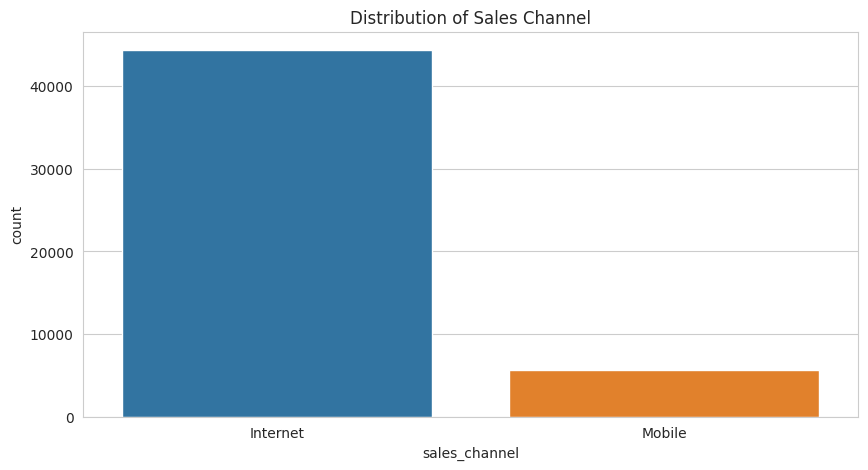

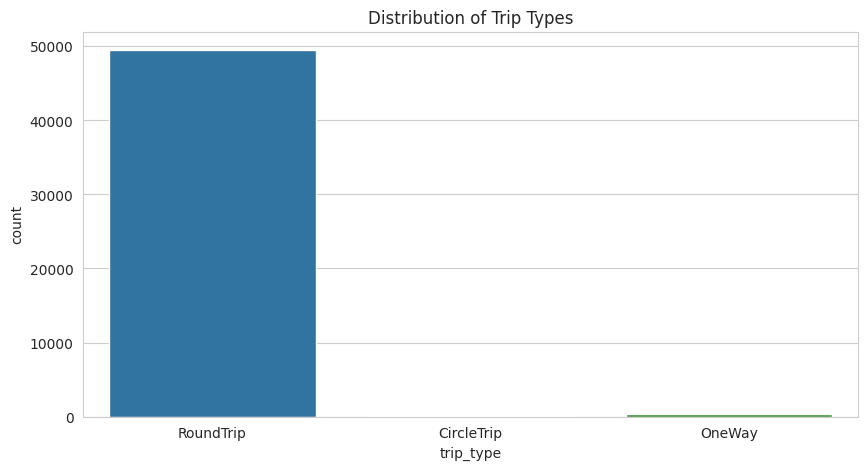

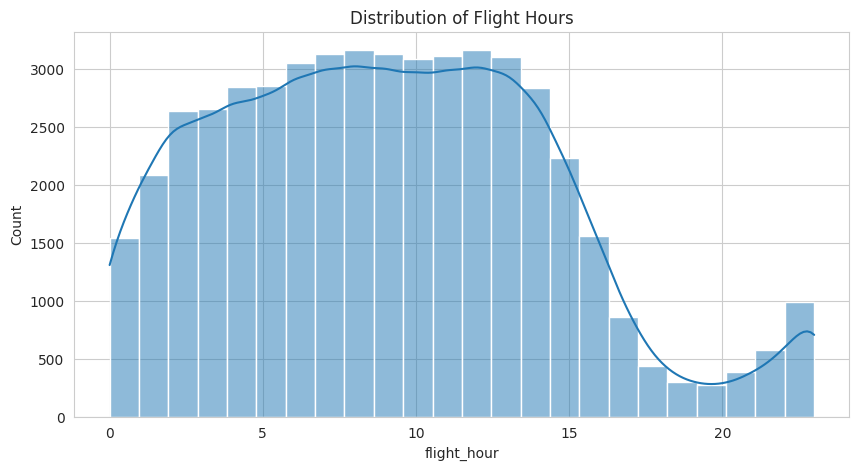

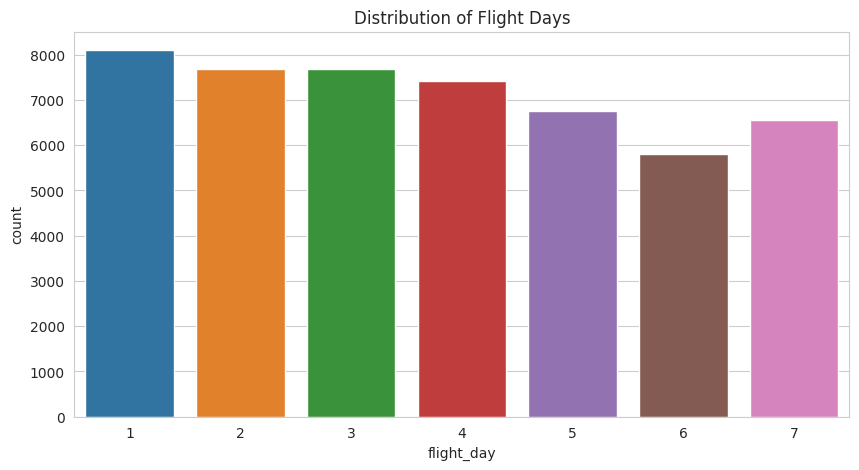

In [ ]:
# Set style for seaborn
sns.set_style("whitegrid")

# Sales Channel distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='sales_channel')
plt.title('Distribution of Sales Channel')
plt.show()

# Trip Type distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='trip_type')
plt.title('Distribution of Trip Types')
plt.show()

# Flight Hour distribution
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='flight_hour', bins=24, kde=True)
plt.title('Distribution of Flight Hours')
plt.show()

# Flight Day distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='flight_day')
plt.title('Distribution of Flight Days')
plt.show()

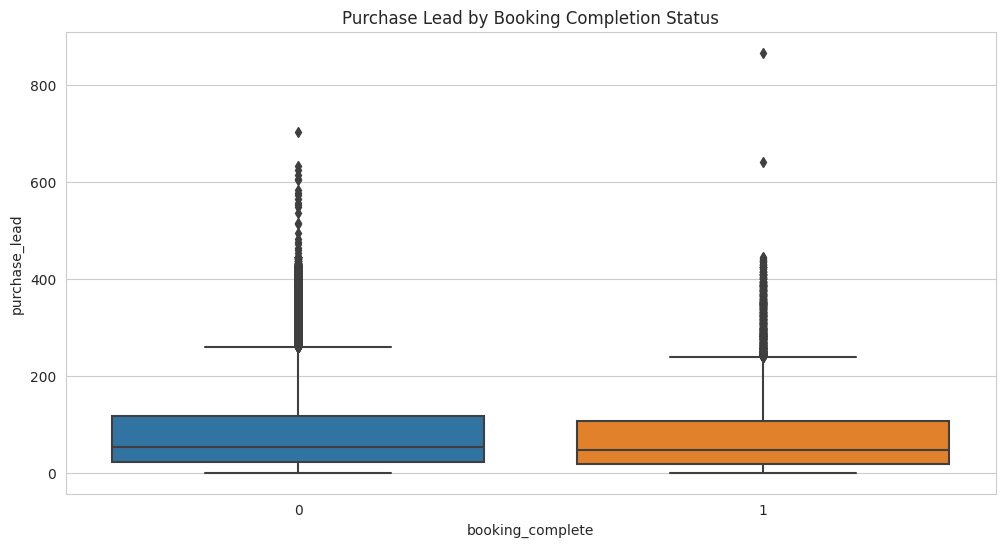

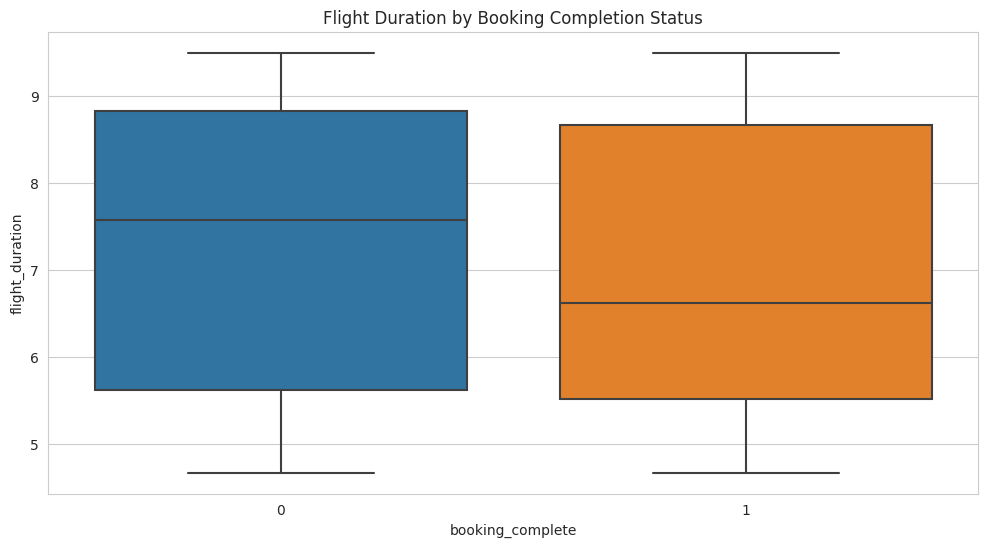

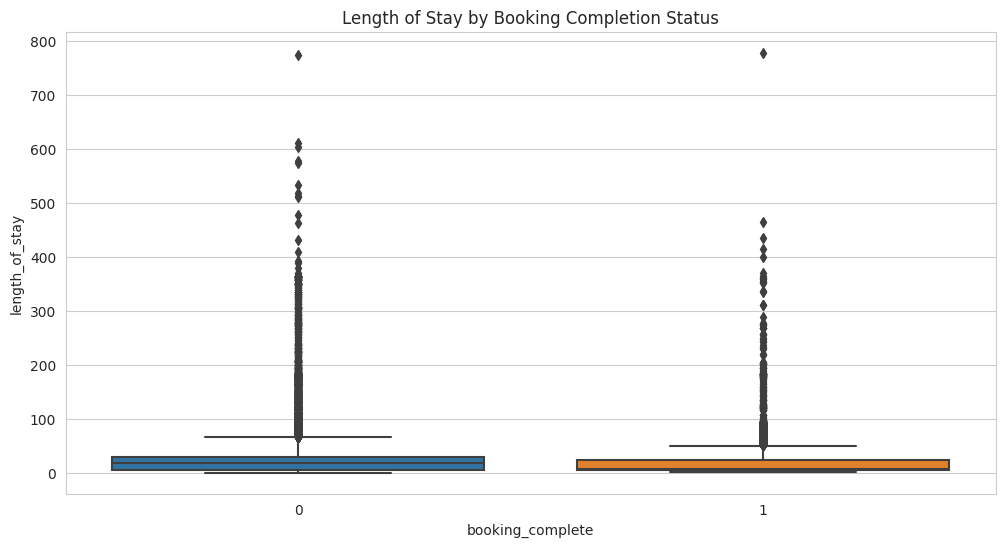

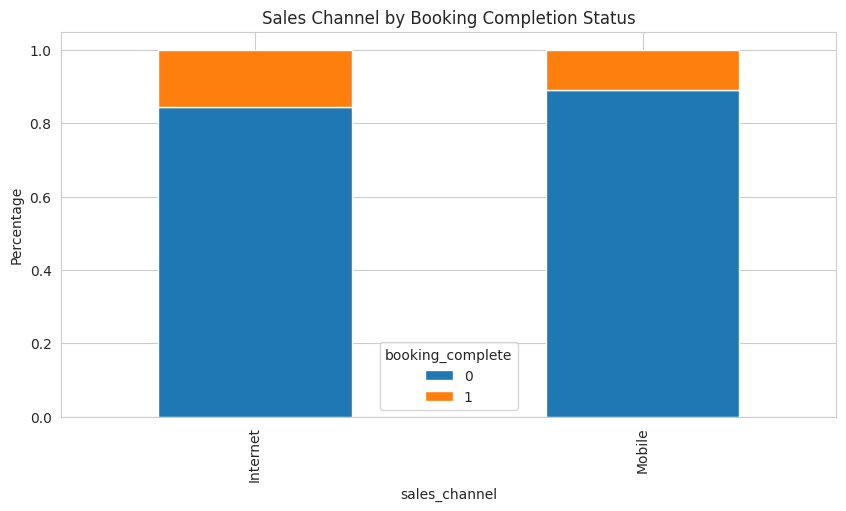

In [ ]:
# Purchase Lead vs Booking Complete
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='booking_complete', y='purchase_lead')
plt.title('Purchase Lead by Booking Completion Status')
plt.show()

# Flight Duration vs Booking Complete
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='booking_complete', y='flight_duration')
plt.title('Flight Duration by Booking Completion Status')
plt.show()

# Length of Stay vs Booking Complete
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='booking_complete', y='length_of_stay')
plt.title('Length of Stay by Booking Completion Status')
plt.show()

# Sales Channel vs Booking Complete (Stacked bar plot)
sales_dist = df.groupby(['sales_channel', 'booking_complete']).size().unstack()
sales_dist_percentage = (sales_dist.T / sales_dist.T.sum()).T
sales_dist_percentage.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Sales Channel by Booking Completion Status')
plt.ylabel('Percentage')
plt.show()


<ipython-input-13-6ce9b8ff709c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


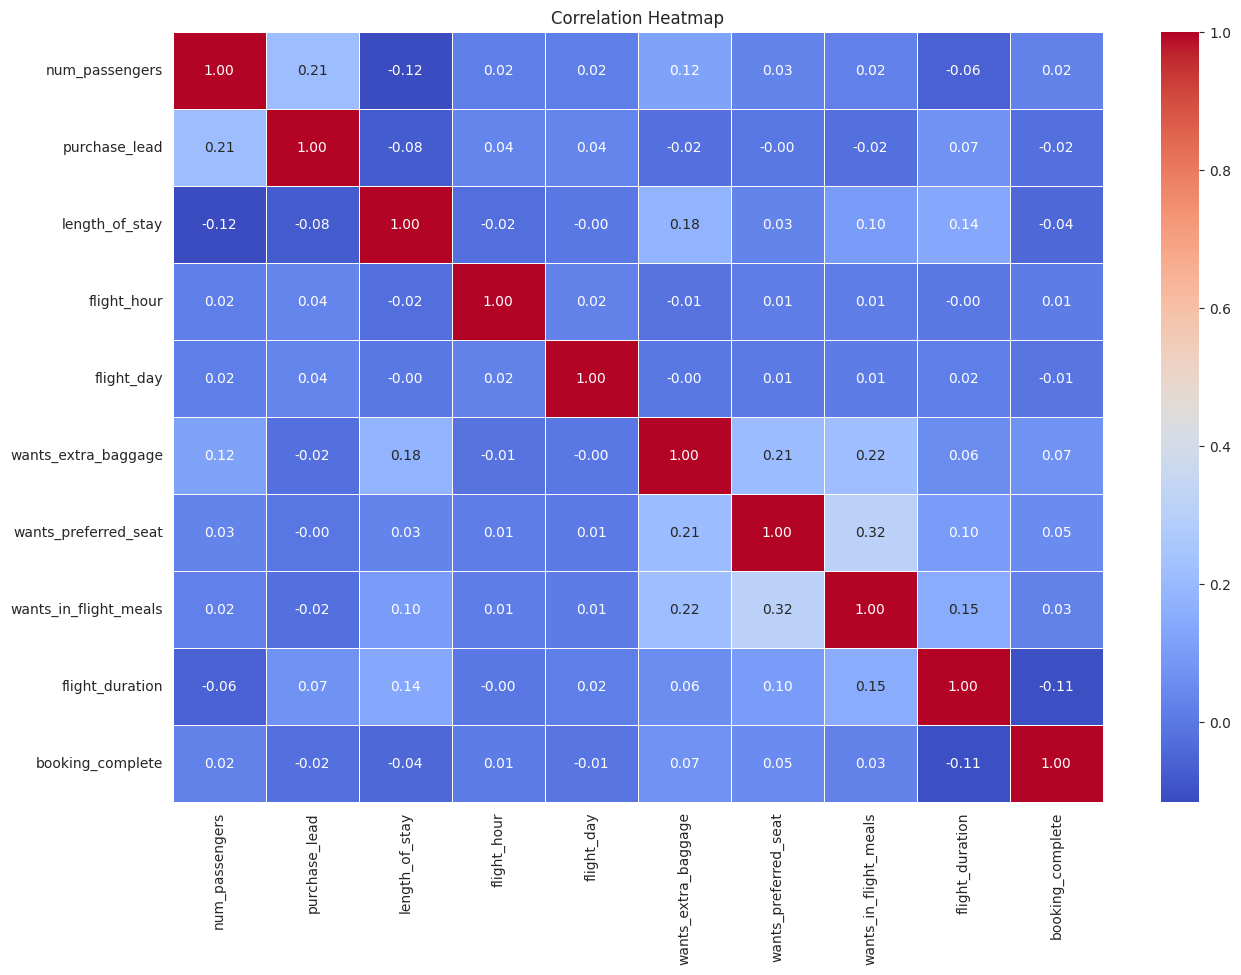

In [ ]:
# Compute the correlation matrix
corr = df.corr()

# Plotting the heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=.5, fmt= '.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Compute the correlation matrix
corr = df.corr()
print(corr)


                       num_passengers  purchase_lead  length_of_stay  \
num_passengers               1.000000       0.212606       -0.115850   
purchase_lead                0.212606       1.000000       -0.076560   
length_of_stay              -0.115850      -0.076560        1.000000   
flight_hour                  0.015607       0.035973       -0.024872   
flight_day                   0.015407       0.036531       -0.000310   
wants_extra_baggage          0.120404      -0.022207        0.176757   
wants_preferred_seat         0.028544      -0.004499        0.032264   
wants_in_flight_meals        0.022943      -0.022653        0.098828   
flight_duration             -0.063169       0.067866        0.141181   
booking_complete             0.024116      -0.022131       -0.042408   

                       flight_hour  flight_day  wants_extra_baggage  \
num_passengers            0.015607    0.015407             0.120404   
purchase_lead             0.035973    0.036531            -0.0222

<ipython-input-14-92dbd4ad0954>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


In [ ]:


# Setting up the dependent and independent variables
X = sm.add_constant(df['wants_in_flight_meals'])
y = df['wants_preferred_seat']

# Running the OLS regression
model = sm.OLS(y, X).fit()

# Printing the results
print(model.summary())


                             OLS Regression Results                             
Dep. Variable:     wants_preferred_seat   R-squared:                       0.099
Model:                              OLS   Adj. R-squared:                  0.099
Method:                   Least Squares   F-statistic:                     5511.
Date:                  Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                          02:05:32   Log-Likelihood:                -29170.
No. Observations:                 50000   AIC:                         5.834e+04
Df Residuals:                     49998   BIC:                         5.836e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [ ]:
# Independent variables
X = sm.add_constant(df[['wants_in_flight_meals', 'wants_extra_baggage']])
y = df['wants_preferred_seat']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     wants_preferred_seat   R-squared:                       0.120
Model:                              OLS   Adj. R-squared:                  0.120
Method:                   Least Squares   F-statistic:                     3399.
Date:                  Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                          02:08:17   Log-Likelihood:                -28598.
No. Observations:                 50000   AIC:                         5.720e+04
Df Residuals:                     49997   BIC:                         5.723e+04
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

# Model implementation

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()

# Print columns with missing values
print(missing_values[missing_values > 0])


Series([], dtype: int64)


In [ ]:
# Defining our independent variables (features) and dependent variable (target)
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
non_numeric_cols = df.select_dtypes(include=['object']).columns
print(non_numeric_cols)

df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index([], dtype='object')


In [ ]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Test

In [ ]:
# Predict the labels for the test set
y_pred = rf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 85.31%


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.51      0.14      0.22      1480

    accuracy                           0.85     10000
   macro avg       0.69      0.56      0.57     10000
weighted avg       0.81      0.85      0.82     10000



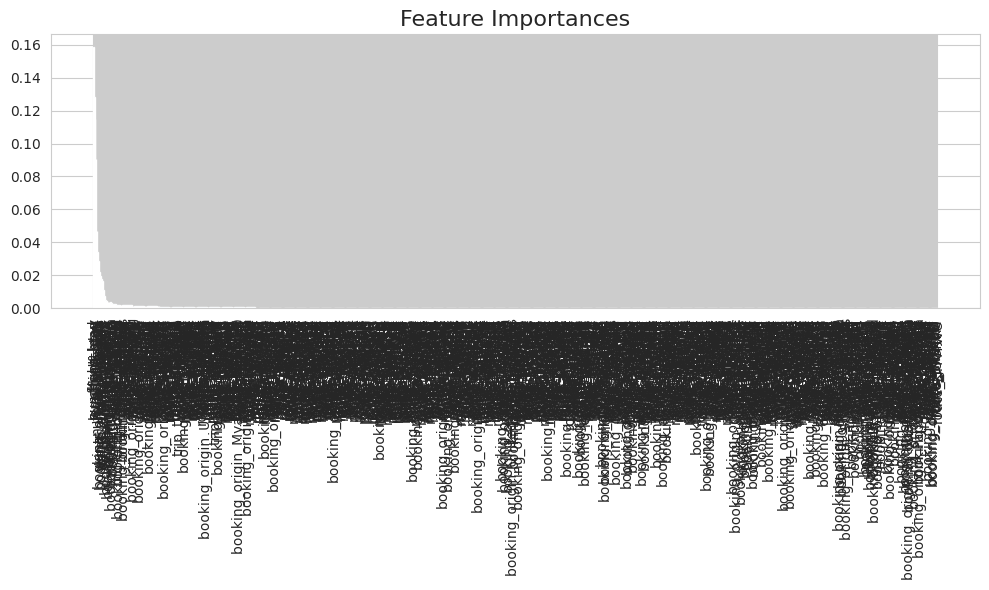

In [ ]:
# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances", fontsize=16)
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


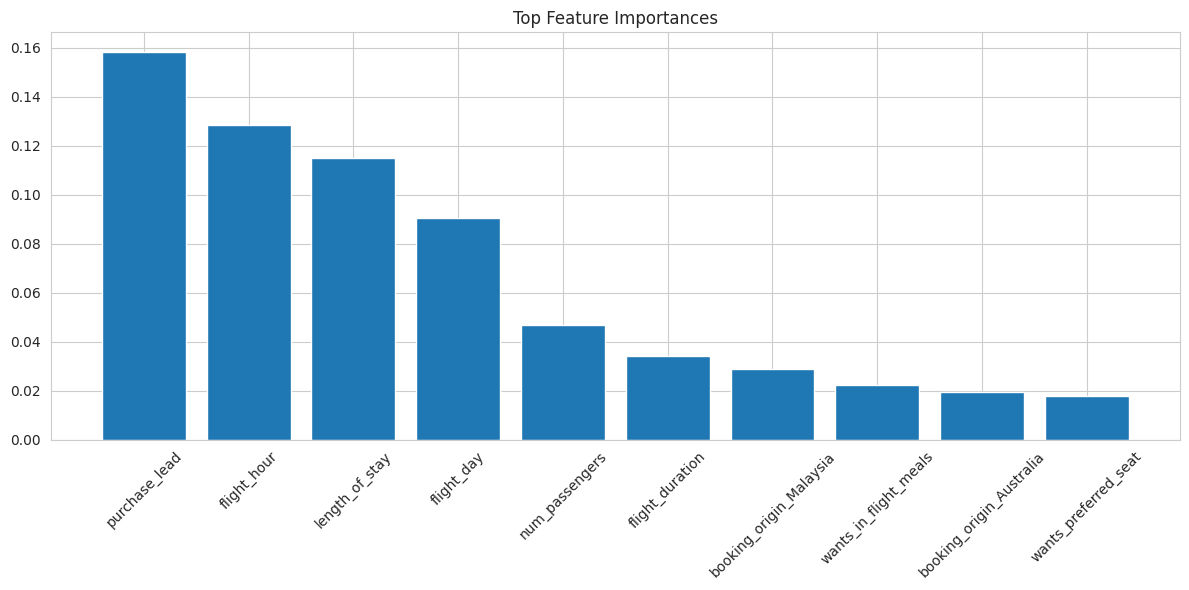

In [ ]:
#Lets clean this up

# Number of top features you want to display
num_top_features = 10

# Get feature importances from the trained RandomForest model
importances = rf.feature_importances_

# Sort feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Extract the names of the top features
top_feature_names = [X.columns[i] for i in indices[:num_top_features]]

# Plot the top feature importances
plt.figure(figsize=(12, 6))
plt.title("Top Feature Importances")
plt.bar(range(num_top_features), importances[indices[:num_top_features]], align="center")
plt.xticks(range(num_top_features), top_feature_names, rotation=45)
plt.tight_layout()
plt.show()




In [ ]:
#cross validation
from sklearn.model_selection import cross_val_score

# Using 5-fold cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
avg_score = np.mean(scores)
print(f"Average Cross-Validation Accuracy: {avg_score*100:.2f}%")


Average Cross-Validation Accuracy: 84.85%


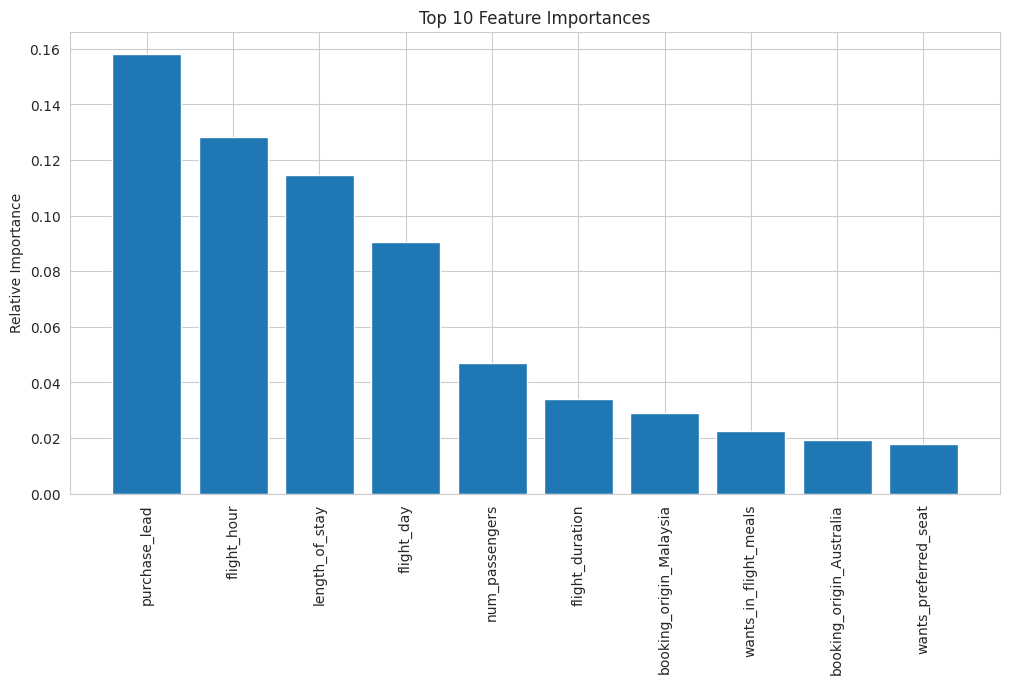

In [ ]:
import matplotlib.pyplot as plt

# Getting feature importances from the trained model
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Taking top features (e.g., top 10)
top_features = 10

plt.figure(figsize=(12, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), feature_importances[indices[:top_features]], align='center')
plt.xticks(range(top_features), X.columns[indices[:top_features]], rotation=90)
plt.ylabel('Relative Importance')
plt.show()
